# --- 1. Environment setup ---

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
project_root = '/content/drive/My Drive/nc_diffusion_colab'
sys.path.append(project_root)

# Install PyYAML to read the config file
!pip install -q pyyaml

print("✅ Setup complete. Google Drive is mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete. Google Drive is mounted.


# ---CD to right directory---

In [4]:
%cd /content/drive/My Drive/nc_diffusion

/content/drive/My Drive/nc_diffusion


#--- 2.Import necessary packages---

In [5]:
import os
import yaml
import torch
import torch.nn as nn
import numpy as np

# Import our custom plotter module
import plotter

# --- 3. Net & exact solution ---

In [6]:
# Load the configuration file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Create the output directory on Google Drive
output_dir = config['paths']['output_dir']
os.makedirs(output_dir, exist_ok=True)

# --- Function and Model Definitions ---
def exact_solution(x, t):
    """Calculates the exact solution of the PDE."""
    return torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * t)

class Net(nn.Module):
    """Defines the neural network model."""
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x_rho):
        return self.network(x_rho)

print(f"✅ Config loaded. Results will be saved to: {output_dir}")

✅ Config loaded. Results will be saved to: /content/drive/MyDrive/nc_diffusion


# --- 3. Training ---

In [7]:
# Get parameters from the config object
p = config['physics']
t = config['training']
DT = (p['t_max'] - p['t_min']) / (p['nt'] - 1)

# Setup the training environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.linspace(p['x_min'], p['x_max'], p['nx'], device=device).view(-1, 1)
x.requires_grad = True
time_steps = torch.linspace(p['t_min'], p['t_max'], p['nt'], device=device)

net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=t['learning_rate'])
loss_history = []

print(f"Using device: {device}. Starting training...")

# --- Training Loop ---
for epoch in range(t['epochs']):
    optimizer.zero_grad()

    rho_current = exact_solution(x, torch.tensor(0.0, device=device))
    J_current = torch.ones_like(x, device=device)
    rho_initial = rho_current.clone()
    total_loss = 0.0

    for n in range(p['nt'] - 1):
        net_input = torch.cat([x, rho_current], dim=1)
        u_current = net(net_input)

        du_dx = torch.autograd.grad(u_current, x, grad_outputs=torch.ones_like(u_current), create_graph=True)[0]
        J_next = J_current * (1 + DT * du_dx)
        rho_next = rho_initial / J_next

        rho_t = (rho_next - rho_current) / DT
        drho_dx = torch.autograd.grad(rho_next, x, grad_outputs=torch.ones_like(rho_next), create_graph=True)[0]
        d2rho_dx2 = torch.autograd.grad(drho_dx, x, grad_outputs=torch.ones_like(drho_dx), create_graph=True)[0]

        pde_residual = rho_t - d2rho_dx2
        loss_pde = torch.mean(pde_residual**2)
        boundary_rho = torch.cat((rho_next[0], rho_next[-1]))
        loss_bc = torch.mean(boundary_rho**2)
        total_loss += (loss_pde + loss_bc)

        rho_current = rho_next.detach()
        J_current = J_next.detach()

    total_loss.backward()
    optimizer.step()
    loss_history.append(total_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{t['epochs']}], Loss: {total_loss.item():.6f}")

print("✅ Training complete!")

Using device: cuda. Starting training...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/1000], Loss: 216.834961
Epoch [200/1000], Loss: 25.517286
Epoch [300/1000], Loss: 10.248242
Epoch [400/1000], Loss: 7.741999
Epoch [500/1000], Loss: 6.058129
Epoch [600/1000], Loss: 4.798383
Epoch [700/1000], Loss: 3.899324
Epoch [800/1000], Loss: 3.189547
Epoch [900/1000], Loss: 2.595659
Epoch [1000/1000], Loss: 2.093124
✅ Training complete!


# --- 4. Visualization ---

Generating results and creating visualizations...
-> Loss plot saved to /content/drive/MyDrive/nc_diffusion/loss.png
-> State comparison plot saved to /content/drive/MyDrive/nc_diffusion/comparison.png
-> Animation saved to /content/drive/MyDrive/nc_diffusion/animation.gif

✅ All tasks complete!


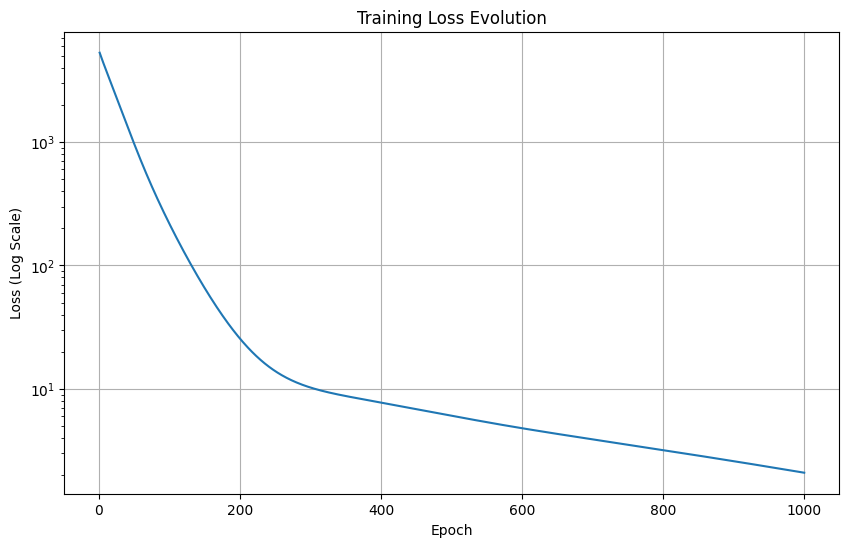

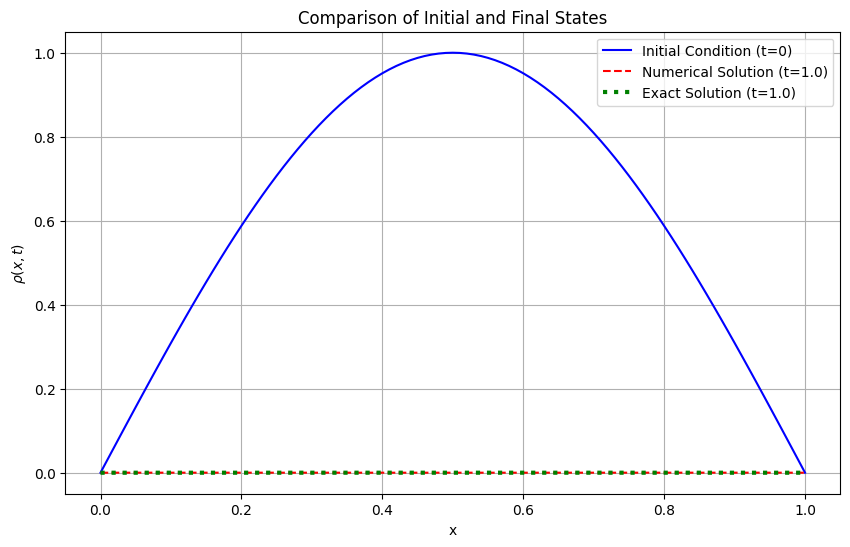

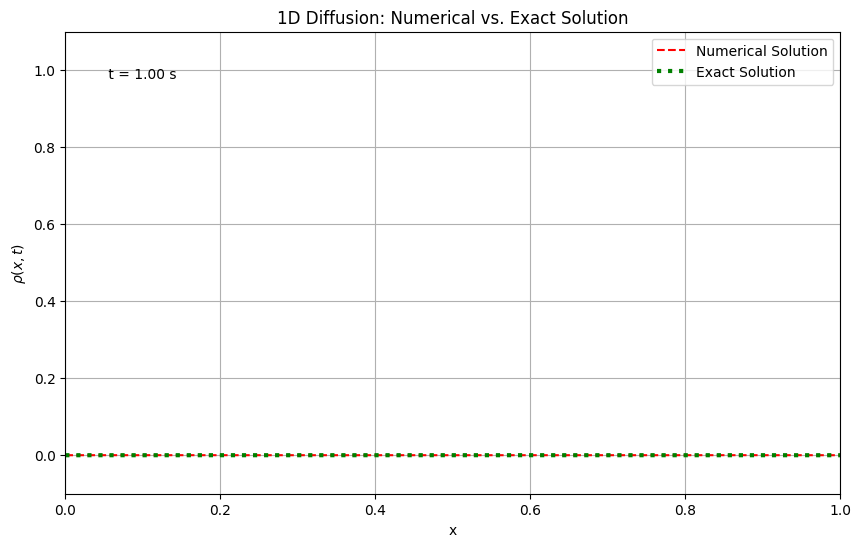

In [8]:
print("Generating results and creating visualizations...")
net.eval()

# Generate numerical and exact solution histories
p = config['physics']
rho_numerical_history = []
rho_current = exact_solution(x, torch.tensor(0.0, device=device))
J_current = torch.ones_like(x, device=device)
rho_initial = rho_current.clone().detach()
rho_numerical_history.append(rho_current.cpu().detach().numpy())

for n in range(p['nt'] - 1):

    net_input = torch.cat([x, rho_current], dim=1)
    u_current = net(net_input)
    du_dx = torch.autograd.grad(u_current, x, grad_outputs=torch.ones_like(u_current))[0]
    J_next = J_current * (1 + DT * du_dx)
    rho_next = rho_initial / J_next
    rho_numerical_history.append(rho_next.cpu().numpy())
    rho_current = rho_next
    J_current = J_next

x_np = x.cpu().detach().numpy()
rho_exact_history = [exact_solution(x.detach(), t_val).cpu().numpy() for t_val in time_steps]

# Call the plotting functions from the plotter module
plotter.plot_loss(loss_history, config, f"{output_dir}/loss.png")
plotter.plot_comparison(x_np, rho_numerical_history, rho_exact_history, config, f"{output_dir}/comparison.png")
plotter.create_animation(x_np, rho_numerical_history, rho_exact_history, time_steps, config, f"{output_dir}/animation.gif")

print("\n✅ All tasks complete!")